# User Inputs

In [3]:
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sqlalchemy import create_engine

import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [56]:
#==========
# General Setting
#==========

# set core path
path = '/Users/Mark/Documents/Github/Fantasy_Football/'

db_name = 'Model_Inputs.sqlite3'

# set to position to analyze: 'RB', 'WR', 'QB', or 'TE'
set_pos = 'RB'


#==========
# Postgres Database
#==========

# postgres login information
pg_log = {
    'USER': 'postgres',
    'PASSWORD': 'Ctdim#1bf!!!!!',
    'HOST': 'localhost',
    'PORT': '5432', 
    'DATABASE_NAME': 'fantasyfootball'
}

# create engine for connecting to database
engine = create_engine('postgres+psycopg2://{}:{}@{}:{}/{}'.format(pg_log['USER'], pg_log['PASSWORD'], pg_log['HOST'],
                                                                   pg_log['PORT'], pg_log['DATABASE_NAME']))

# specify schema and table to write out intermediate results
table_info = {
    'engine': engine,
    'schema': 'websitedev',
}

#==========
# Data Filtering
#==========

# set year to analyze
set_year = 2018
earliest_year = 2001

# set required touches (or pass thrown) and games for consideration
req_games = 8
req_touch = 50


#==========
# Fantasy Point Values
#==========

# define point values for all statistical categories
pass_yd_per_pt = 0.04 
pass_td_pt = 5
int_pts = -2
sacks = -1
rush_yd_per_pt = 0.1 
rec_yd_per_pt = 0.1
rush_rec_td = 7
ppr = 0.5

# creating dictionary containing point values for each position
pts_dict = {}
pts_dict['QB'] = [pass_yd_per_pt, pass_td_pt, rush_yd_per_pt, rush_rec_td, int_pts, sacks]
pts_dict['RB'] = [rush_yd_per_pt, rec_yd_per_pt, ppr, rush_rec_td]
pts_dict['WR'] = [rec_yd_per_pt, ppr, rush_rec_td]
pts_dict['TE'] = [rec_yd_per_pt, ppr, rush_rec_td]


#==========
# Model Settings
#==========

# correlation with target for initial feature reduction
corr_cutoff = 0.25

# VIF threshold to include remaining features
vif_thresh = 1000

# number of hypersearch rounds for training ensemble
iter_rounds = 25

# whether or not to plot feature importances following modeling
plot_importance = True

# Load Libraries

In [36]:
# core packages
import pandas as pd
import numpy as np
import os
import sqlite3

# jupyter specifications
pd.options.mode.chained_assignment = None
from IPython.core.interactiveshell import InteractiveShell
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# plotting functions
import matplotlib.pyplot as plt
import seaborn as sns

In [37]:
# change directory temporarily to helper scripts
os.chdir(path + 'Scripts/Analysis/Helper_Scripts')

# load custom plot functions
from my_plot import PrettyPlot
PrettyPlot(plt)

# load custom helper functions and ensure lightgbm runs
from helper_functions import *
os.environ['KMP_DUPLICATE_LIB_OK']='True';

# Merge and Clean Data Files

In [38]:
#==========
# Pull and clean compiled data
#==========

# connect to database and pull in positional data
conn = sqlite3.connect(path + 'Data/' + db_name)
df = pd.read_sql_query('SELECT * FROM ' + set_pos + '_2018', con=conn)

# split old and new to filter past years based on touches.
# leave all new players in to ensure everyone gets a prediction
old = df[(df[pos[set_pos]['touch_filter']] > req_touch) & (df.games > req_games) & (df.year < set_year-1)].reset_index(drop=True)
this_year = df[df.year==set_year-1]

# merge old and new back together after filtering
df = pd.concat([old, this_year], axis=0)

# create dataframes to store results
df_train_results = pd.DataFrame([old.player, old.year]).T
df_test_results = pd.DataFrame([this_year.player]).T

# calculate FP and generate list of relevant metrics
df, pts_list = calculate_fp(df, pts, pos=set_pos)

Running Models for rush_yd_per_game
----------------------------------
Corr removed  149 / 205  features
Running VIF Feature Reduction
Dropped  14 / 54  columns
Training Ensemble Model
2019-06-01 13:14:35
Completed 10/10 iterations
    lgbm    xgb  lasso  ridge   rmse    mae  r2_pred  c_pred  r2_adp  c_adp
0  0.254  0.255  0.246  0.245  17.84  14.29    0.516   0.718   0.418  0.646
5  0.250  0.255  0.250  0.244  18.12  14.62    0.502   0.709   0.418  0.646
7  0.248  0.255  0.251  0.245  18.17  14.72    0.505   0.710   0.418  0.646
8  0.247  0.253  0.250  0.249  18.30  14.79    0.504   0.710   0.418  0.646
6  0.251  0.252  0.248  0.249  18.31  14.79    0.504   0.710   0.418  0.646
2  0.249  0.253  0.249  0.249  18.33  14.83    0.504   0.710   0.418  0.646
9  0.248  0.254  0.251  0.248  18.36  14.87    0.508   0.712   0.418  0.646
1  0.248  0.252  0.250  0.250  18.36  14.81    0.503   0.709   0.418  0.646
4  0.251  0.252  0.249  0.248  18.39  14.89    0.500   0.707   0.418  0.646
3  0.245

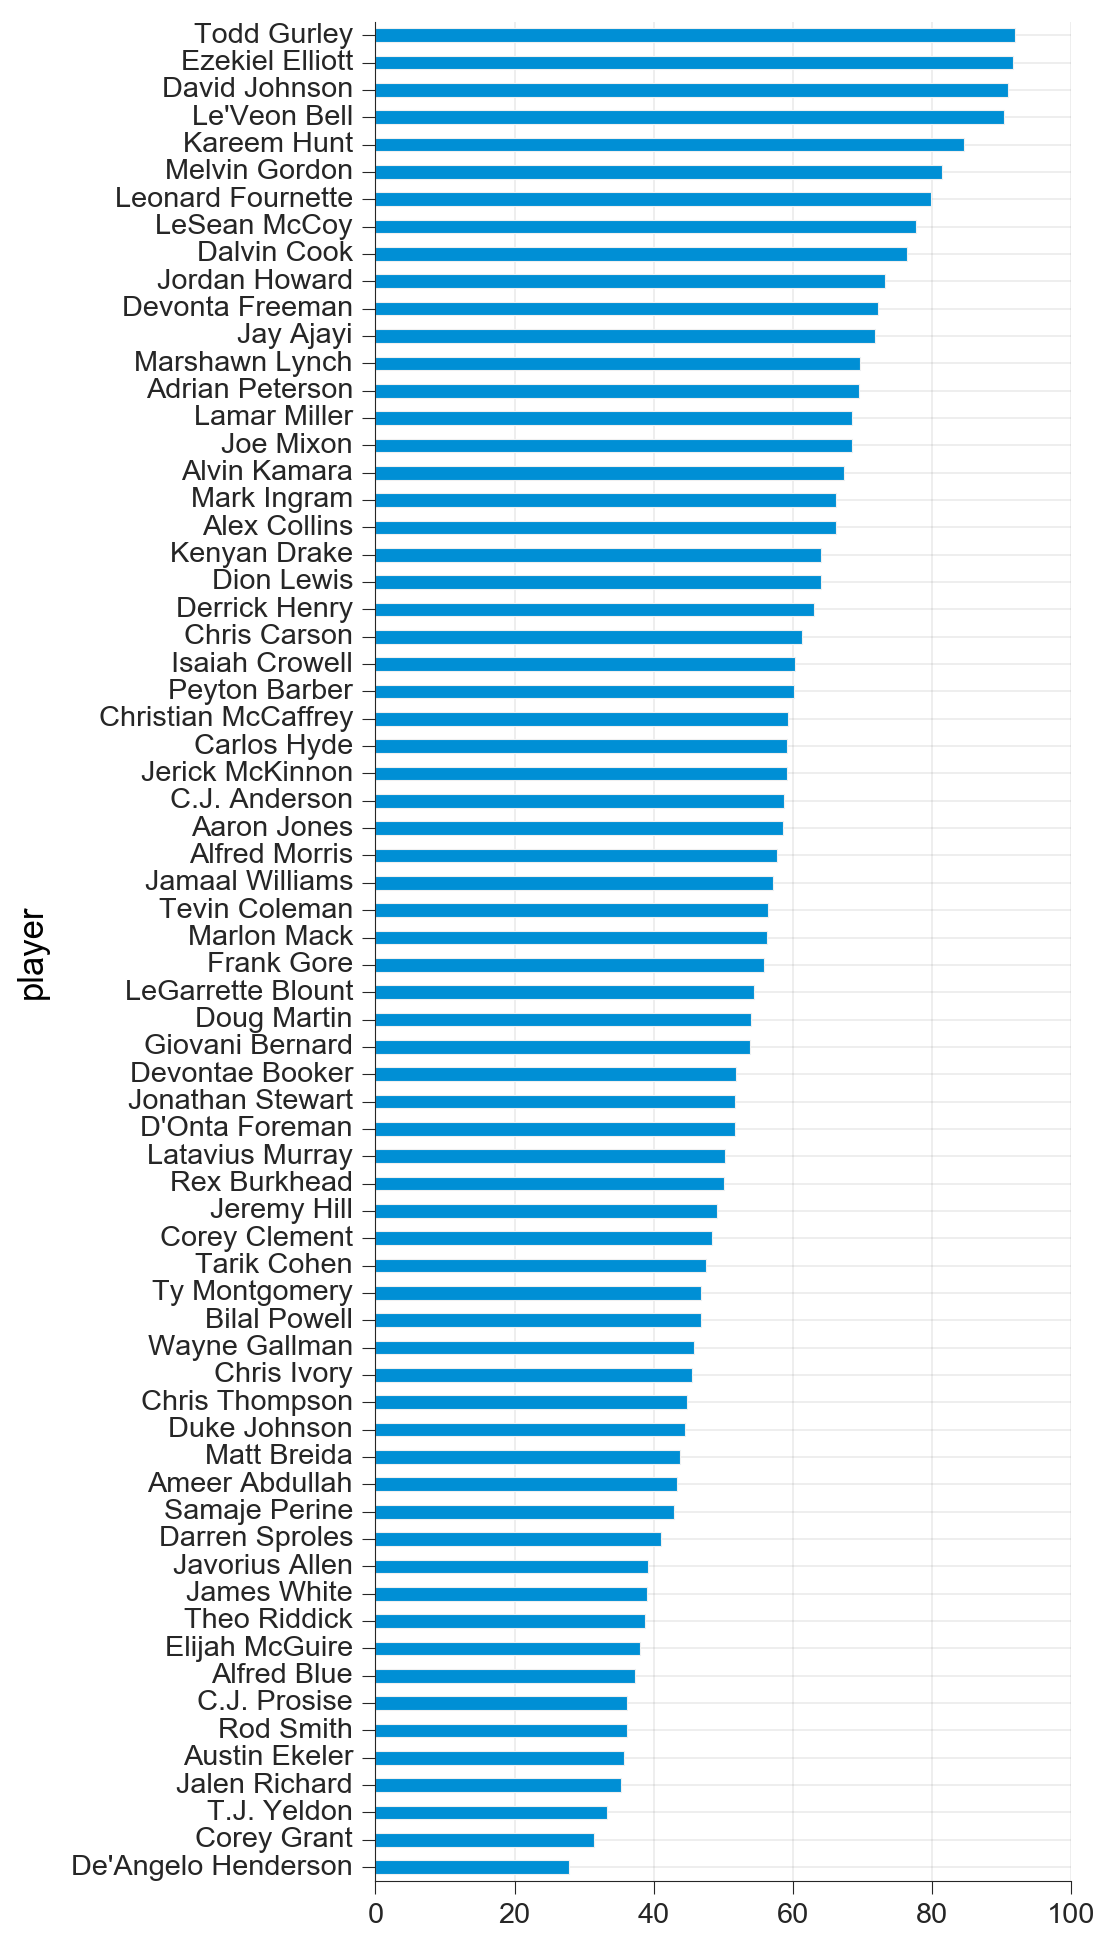

Running Models for rec_yd_per_game
----------------------------------
Corr removed  165 / 205  features
Running VIF Feature Reduction
Dropped  7 / 38  columns
Training Ensemble Model
2019-06-01 13:15:04
Completed 10/10 iterations
    lgbm    xgb  lasso  ridge  rmse   mae  r2_pred  c_pred  r2_adp  c_adp
9  0.248  0.252  0.250  0.250  8.92  6.77    0.402   0.634   0.056  0.236
1  0.246  0.253  0.249  0.252  8.92  6.81    0.400   0.633   0.056  0.236
0  0.248  0.251  0.250  0.252  8.93  6.85    0.393   0.627   0.056  0.236
2  0.249  0.251  0.248  0.252  8.94  6.79    0.395   0.629   0.056  0.236
4  0.250  0.251  0.249  0.251  8.95  6.80    0.394   0.628   0.056  0.236
3  0.245  0.252  0.250  0.253  8.96  6.82    0.396   0.630   0.056  0.236
8  0.246  0.250  0.251  0.253  9.00  6.82    0.391   0.625   0.056  0.236
6  0.250  0.249  0.248  0.253  9.01  6.85    0.383   0.619   0.056  0.236
5  0.248  0.248  0.252  0.252  9.04  6.87    0.389   0.624   0.056  0.236
7  0.248  0.248  0.252  0.252 

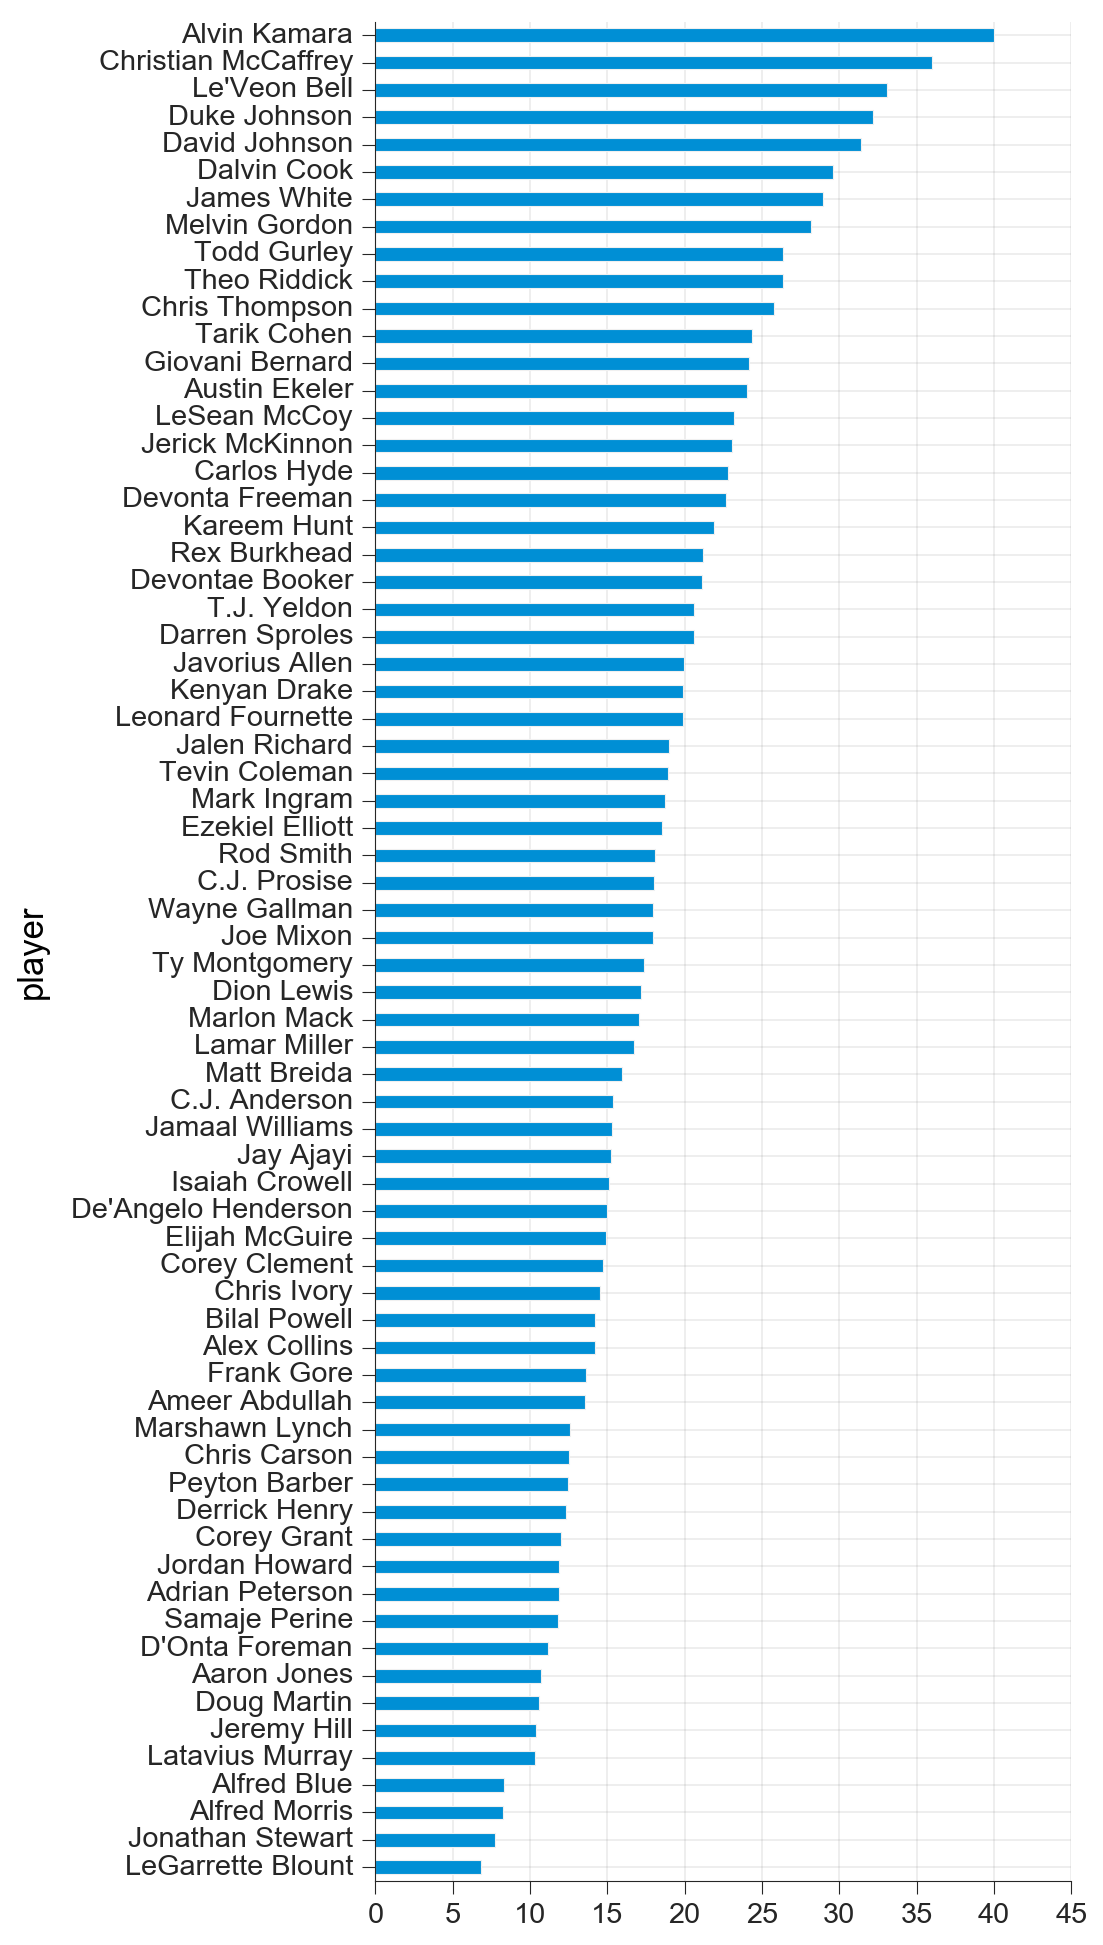

Running Models for rec_per_game
----------------------------------
Corr removed  164 / 205  features
Running VIF Feature Reduction
Dropped  7 / 39  columns
Training Ensemble Model
2019-06-01 13:15:32
Completed 10/10 iterations
    lgbm    xgb  lasso  ridge  rmse   mae  r2_pred  c_pred  r2_adp  c_adp
9  0.257  0.256  0.230  0.257  0.94  0.74    0.471   0.686   0.088  0.297
2  0.262  0.261  0.213  0.264  0.95  0.75    0.464   0.681   0.088  0.297
7  0.257  0.253  0.233  0.258  0.96  0.76    0.470   0.686   0.088  0.297
4  0.262  0.263  0.212  0.263  0.96  0.75    0.468   0.684   0.088  0.297
1  0.259  0.263  0.214  0.264  0.96  0.75    0.464   0.681   0.088  0.297
6  0.260  0.262  0.213  0.265  0.96  0.76    0.461   0.679   0.088  0.297
0  0.261  0.260  0.214  0.265  0.96  0.76    0.456   0.676   0.088  0.297
3  0.257  0.262  0.216  0.265  0.96  0.76    0.452   0.672   0.088  0.297
8  0.259  0.261  0.215  0.265  0.96  0.75    0.452   0.672   0.088  0.297
5  0.254  0.253  0.235  0.259  0.

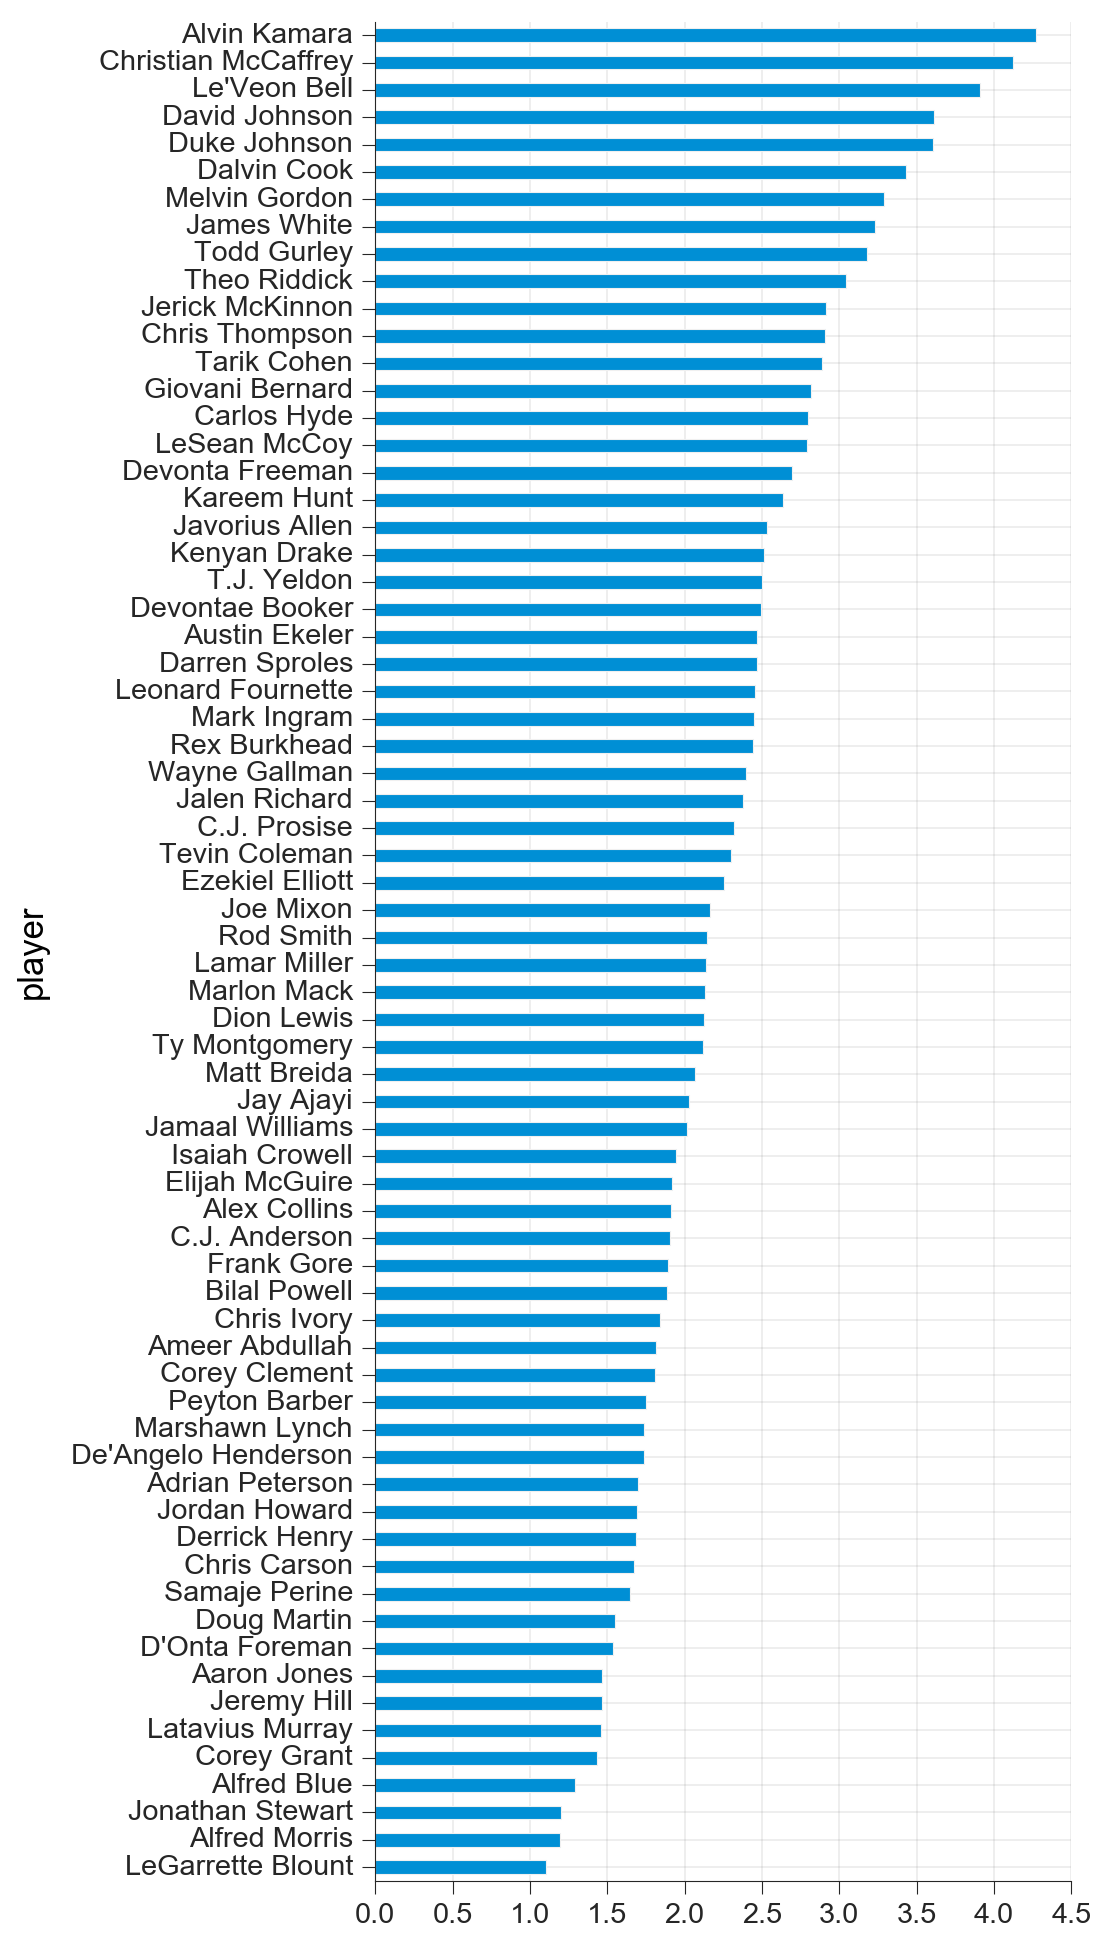

Running Models for td_per_game
----------------------------------
Corr removed  160 / 205  features
Running VIF Feature Reduction
Dropped  12 / 43  columns
Training Ensemble Model
2019-06-01 13:16:03
Completed 10/10 iterations
    lgbm    xgb  lasso  ridge  rmse   mae  r2_pred  c_pred  r2_adp  c_adp
6  0.253  0.253  0.236  0.258  0.24  0.19    0.257   0.507   0.271  0.521
1  0.253  0.252  0.237  0.258  0.24  0.19    0.250   0.500   0.271  0.521
5  0.253  0.253  0.237  0.257  0.24  0.19    0.249   0.499   0.271  0.521
4  0.252  0.254  0.236  0.258  0.24  0.19    0.246   0.496   0.271  0.521
7  0.252  0.254  0.237  0.257  0.24  0.19    0.244   0.494   0.271  0.521
9  0.251  0.254  0.237  0.258  0.24  0.19    0.242   0.492   0.271  0.521
8  0.252  0.252  0.237  0.258  0.24  0.19    0.241   0.491   0.271  0.521
2  0.253  0.250  0.238  0.259  0.24  0.19    0.238   0.488   0.271  0.521
3  0.251  0.250  0.239  0.260  0.24  0.19    0.232   0.482   0.271  0.521
0  0.248  0.252  0.240  0.261  0.

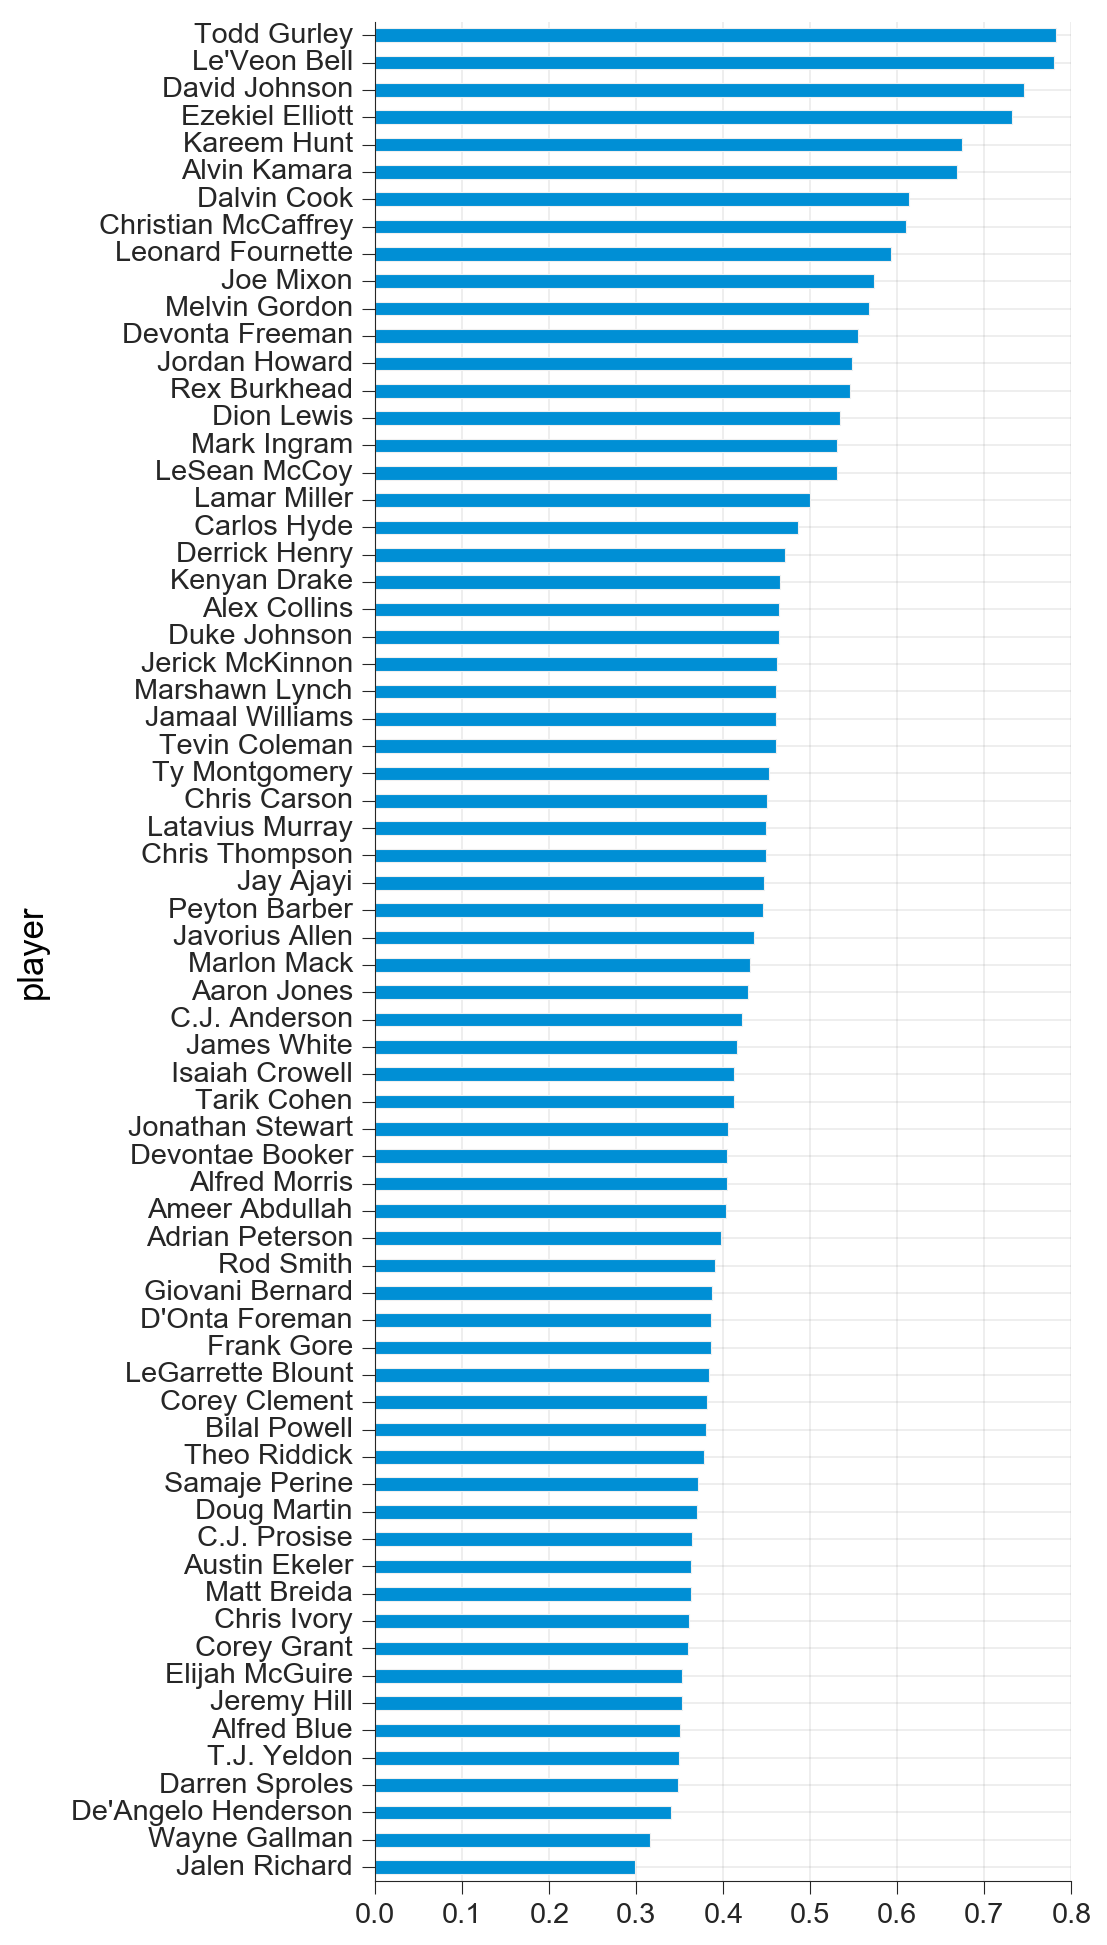

In [39]:
#==========
# Loop to create statistical predictions
#==========

output = {}

for metric in pos[set_pos]['metrics']:
    
    # create dataframes to store chunk data
    df_train_chunks = pd.DataFrame()
    df_test_chunks = pd.DataFrame()

    # print which metric is being calculated
    print('Running Models for ' + metric)
    print('----------------------------------')

    #--------
    # Create train and predict dataframes
    #--------
    
    # create training and prediction dataframes
    df_train_full, df_predict_full = features_target(df,
                                                     earliest_year, set_year-1,
                                                     pos[set_pos]['med_features'],
                                                     pos[set_pos]['sum_features'],
                                                     pos[set_pos]['max_features'],
                                                     pos[set_pos]['age_features'],
                                                     target_feature=metric)
    
    # drop any rows that have a null target value (likely due to injuries or other missed season)
    df_train_full = df_train_full.dropna(subset=['y_act']).reset_index(drop=True)
    df_train_full = df_train_full.fillna(df_train_full.mean())
    df_predict_full = df_predict_full.dropna().reset_index(drop=True)
    
    # loop through different k's specific to draft position cutoffs
    for k in [1]:
        
        if k == 1:
            
            df_train = df_train_full
            df_predict = df_predict_full
            #df_train = df_train_full[df_train_full.avg_pick < 4.6].reset_index(drop=True)
            #df_predict = df_predict_full[df_predict_full.avg_pick < 4.6].reset_index(drop=True)
        
        #if k == 2:
        #    df_train = df_train_full[(df_train_full.avg_pick >= 3.6) & (df_train_full.avg_pick < 4.6)].reset_index(drop=True)
        #    df_predict = df_predict_full[(df_predict_full.avg_pick >= 3.6) & (df_predict_full.avg_pick < 4.6)].reset_index(drop=True)
        
        #if k == 2:
        #    df_train = df_train_full[df_train_full.avg_pick >= 4.6].reset_index(drop=True)
        #    df_predict = df_predict_full[df_predict_full.avg_pick >= 4.6].reset_index(drop=True)
            
        #--------
        # Remove low correlation features and high VIF features
        #--------

        # remove low correlation features
        df_train, df_predict = corr_removal(df_train, df_predict, corr_cutoff=corr_cutoff)

        # select only features with low vif for modeling
        transformer = ReduceVIF(thresh=vif_thresh, scale=True, print_progress=False)
        df_train_ = transformer.fit_transform(df_train.drop(['y_act', 'player'], axis=1), df_train.y_act)

        # extract best columns and filter down df_predict
        best_cols = list(df_train_.columns)
        best_cols.extend(['player', 'year', 'avg_pick'])
        df_predict = df_predict[best_cols]
        df_predict = df_predict.loc[:,~df_predict.columns.duplicated()]

        # add target and filter down df_train
        best_cols.extend(['y_act', 'year', 'avg_pick'])
        df_train = df_train[best_cols]
        df_train = df_train.loc[:,~df_train.columns.duplicated()]

        #--------
        # Run ensemble model with parameter optimization
        #--------

        # generate a master dictionary of parameters (must match the)
        param_list = [lgbm_params, xgb_params, lasso_params, ridge_params]
        est_names = ['lgbm', 'xgb', 'lasso', 'ridge']

        params = {}
        for i, param in enumerate(param_list):
            params[est_names[i]] = param

        print('Training Ensemble Model')
        param_results, summary, df_train_results_, errors = validation(est_names, params, df_train, iterations=iter_rounds, random_state=1234)

        #--------
        # Print best results
        #--------

        # print a summary of error metrics, weightings of various models, and a comparison to 
        # using straight adp as as a prediction for next year's stats
        print(summary.head(10))

        # pull out the best result for the random hyperparameter search of models
        best_result = summary.index[0]

        # pass the best hyperparameters into the generation_prediction function, which
        # will return the test results for the current year and the trained best models
        df_test_results_, models = generate_predictions(best_result, param_results, summary, df_train, df_predict)

        #--------
        # Aggregate all results through merging
        #--------

        # add models to output dictionary
        output[metric] = {}
        output[metric][k] = {}
        output[metric][k]['models'] = models

        # add params to output dictionary
        output[metric][k]['params'] = param_results

        # add columns to output dictionary
        cols = list(df_train.columns)
        cols.remove('y_act')
        cols.remove('player')
        output[metric]['cols'] = cols
        
        # concat the chunk for each metric together into one dataframe
        df_train_results_ = df_train_results_.rename(columns={'pred': 'pred_' + metric})
        df_train_results_ = df_train_results_[['player', 'year', 'pred_' + metric]]
        df_train_chunks = pd.concat([df_train_chunks, df_train_results_], axis=0).reset_index(drop=True)
        
        # concat the chunk for each metric together into one dataframe
        df_test_results_ = df_test_results_.rename(columns={'pred': 'pred_' + metric})
        df_test_results_ = df_test_results_[['player', 'pred_' + metric]]
        df_test_chunks = pd.concat([df_test_chunks, df_test_results_], axis=0).reset_index(drop=True)
    
    # merge the train results for the given metric with all other metric outputs
    df_train_results = pd.merge(df_train_results, df_train_chunks, 
                                how='inner', left_on=['player', 'year'], right_on=['player', 'year'])
    # merge the test results for the given metric with all other metric outputs
    df_test_results = pd.merge(df_test_results, df_test_chunks, 
                               how='inner', left_on='player', right_on='player')

# after loop, set the df_train to have the y_act as fp_per_game
df_train, df_predict = features_target(df, earliest_year, set_year-1, 
                                           pos[set_pos]['med_features'], 
                                           pos[set_pos]['sum_features'],
                                           pos[set_pos]['max_features'], 
                                           pos[set_pos]['age_features'],
                                           target_feature='fp_per_game')

## Write out results to Postgres

In [41]:
#--------
# Append additional stat categories to the results
#--------

# add actual results and adp to the train df
df_train_results = pd.merge(df_train_results, df_train[['player', 'year', 'age', 'avg_pick', 'y_act']],
                           how='inner', left_on=['player', 'year'], right_on=['player', 'year']).drop('year', axis=1)

# add adp to the test df
df_test_results = pd.merge(df_test_results, df_predict[['player', 'age', 'avg_pick']],
                           how='inner', left_on='player', right_on='player')

#--------
# Calculate Fantasy Points for Given Scoring System
#-------- 

# extract points list and get the idx of point attributes based on length of list
pts_list = pts_dict[set_pos]
c_idx = len(pts_list) + 1

# multiply stat categories by corresponding point values
df_train_results.iloc[:, 1:c_idx] = df_train_results.iloc[:, 1:c_idx] * pts_list
df_test_results.iloc[:, 1:c_idx] = df_test_results.iloc[:, 1:c_idx] * pts_list

# add a total predicted points stat category
df_train_results.loc[:, 'pred'] = df_train_results.iloc[:, 1:c_idx].sum(axis=1)
df_test_results.loc[:, 'pred'] = df_test_results.iloc[:, 1:c_idx].sum(axis=1)

#--------
# Set up proper database connections to save out single dataset
#--------

# df_train_results.to_sql(pos[1:] + '_Train_' + str(year), engine, schema='websitedev', index=False)
# df_test_results.to_sql(pos[1:] + '_Test_' + str(year), engine, schema='websitedev', index=False)

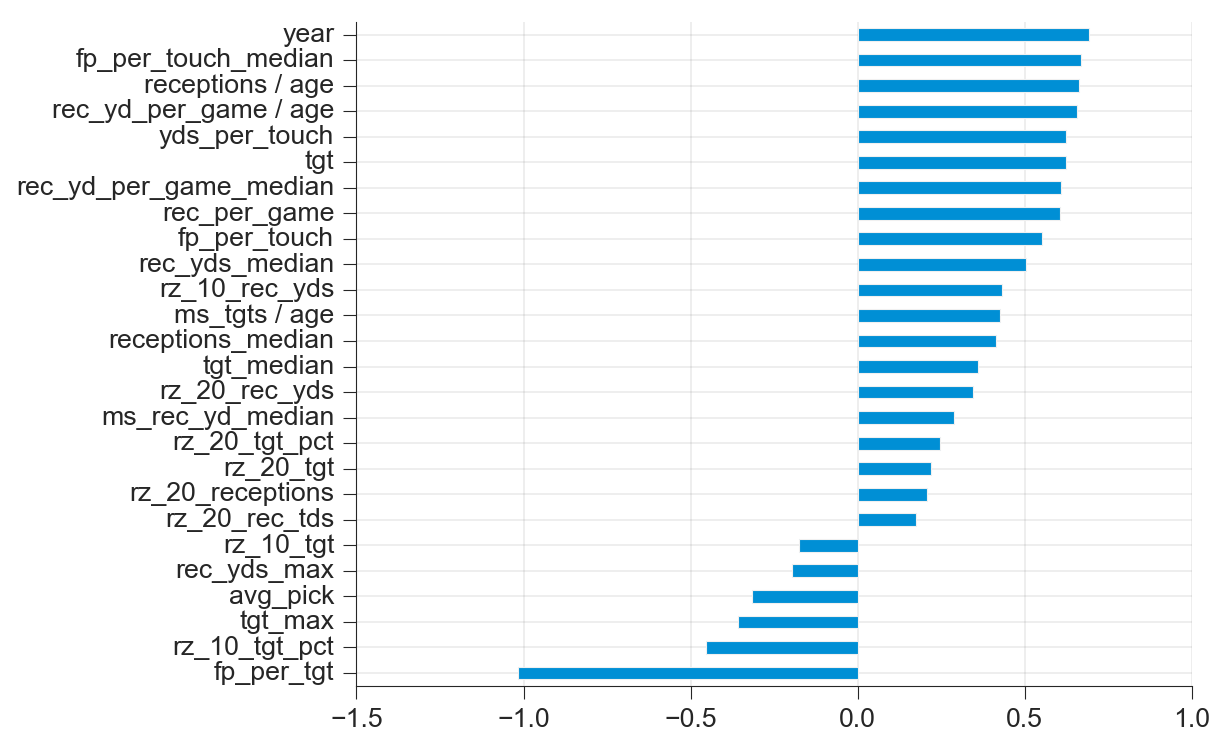

In [74]:
#==========
# If desired, plot feature importances for a given metric / model
#==========

if plot_importance == True:
    
    metric = 'rec_yd_per_game'
    k = 1
    j = 3
    try:
        plot_results(output[metric][k]['models'][j].feature_importances_, col_names=output[metric]['cols']);
    except:
        plot_results(output[metric][k]['models'][j].coef_, col_names=output[metric]['cols']);

In [53]:
train = pd.read_sql_query('SELECT * FROM {}."{}_Train_{}"' \
                                     .format(table_info['schema'], set_pos, str(set_year)), table_info['engine'])
test = pd.read_sql_query('SELECT * FROM {}."{}_Test_{}"' \
                                    .format(table_info['schema'], set_pos, str(set_year)), table_info['engine'])

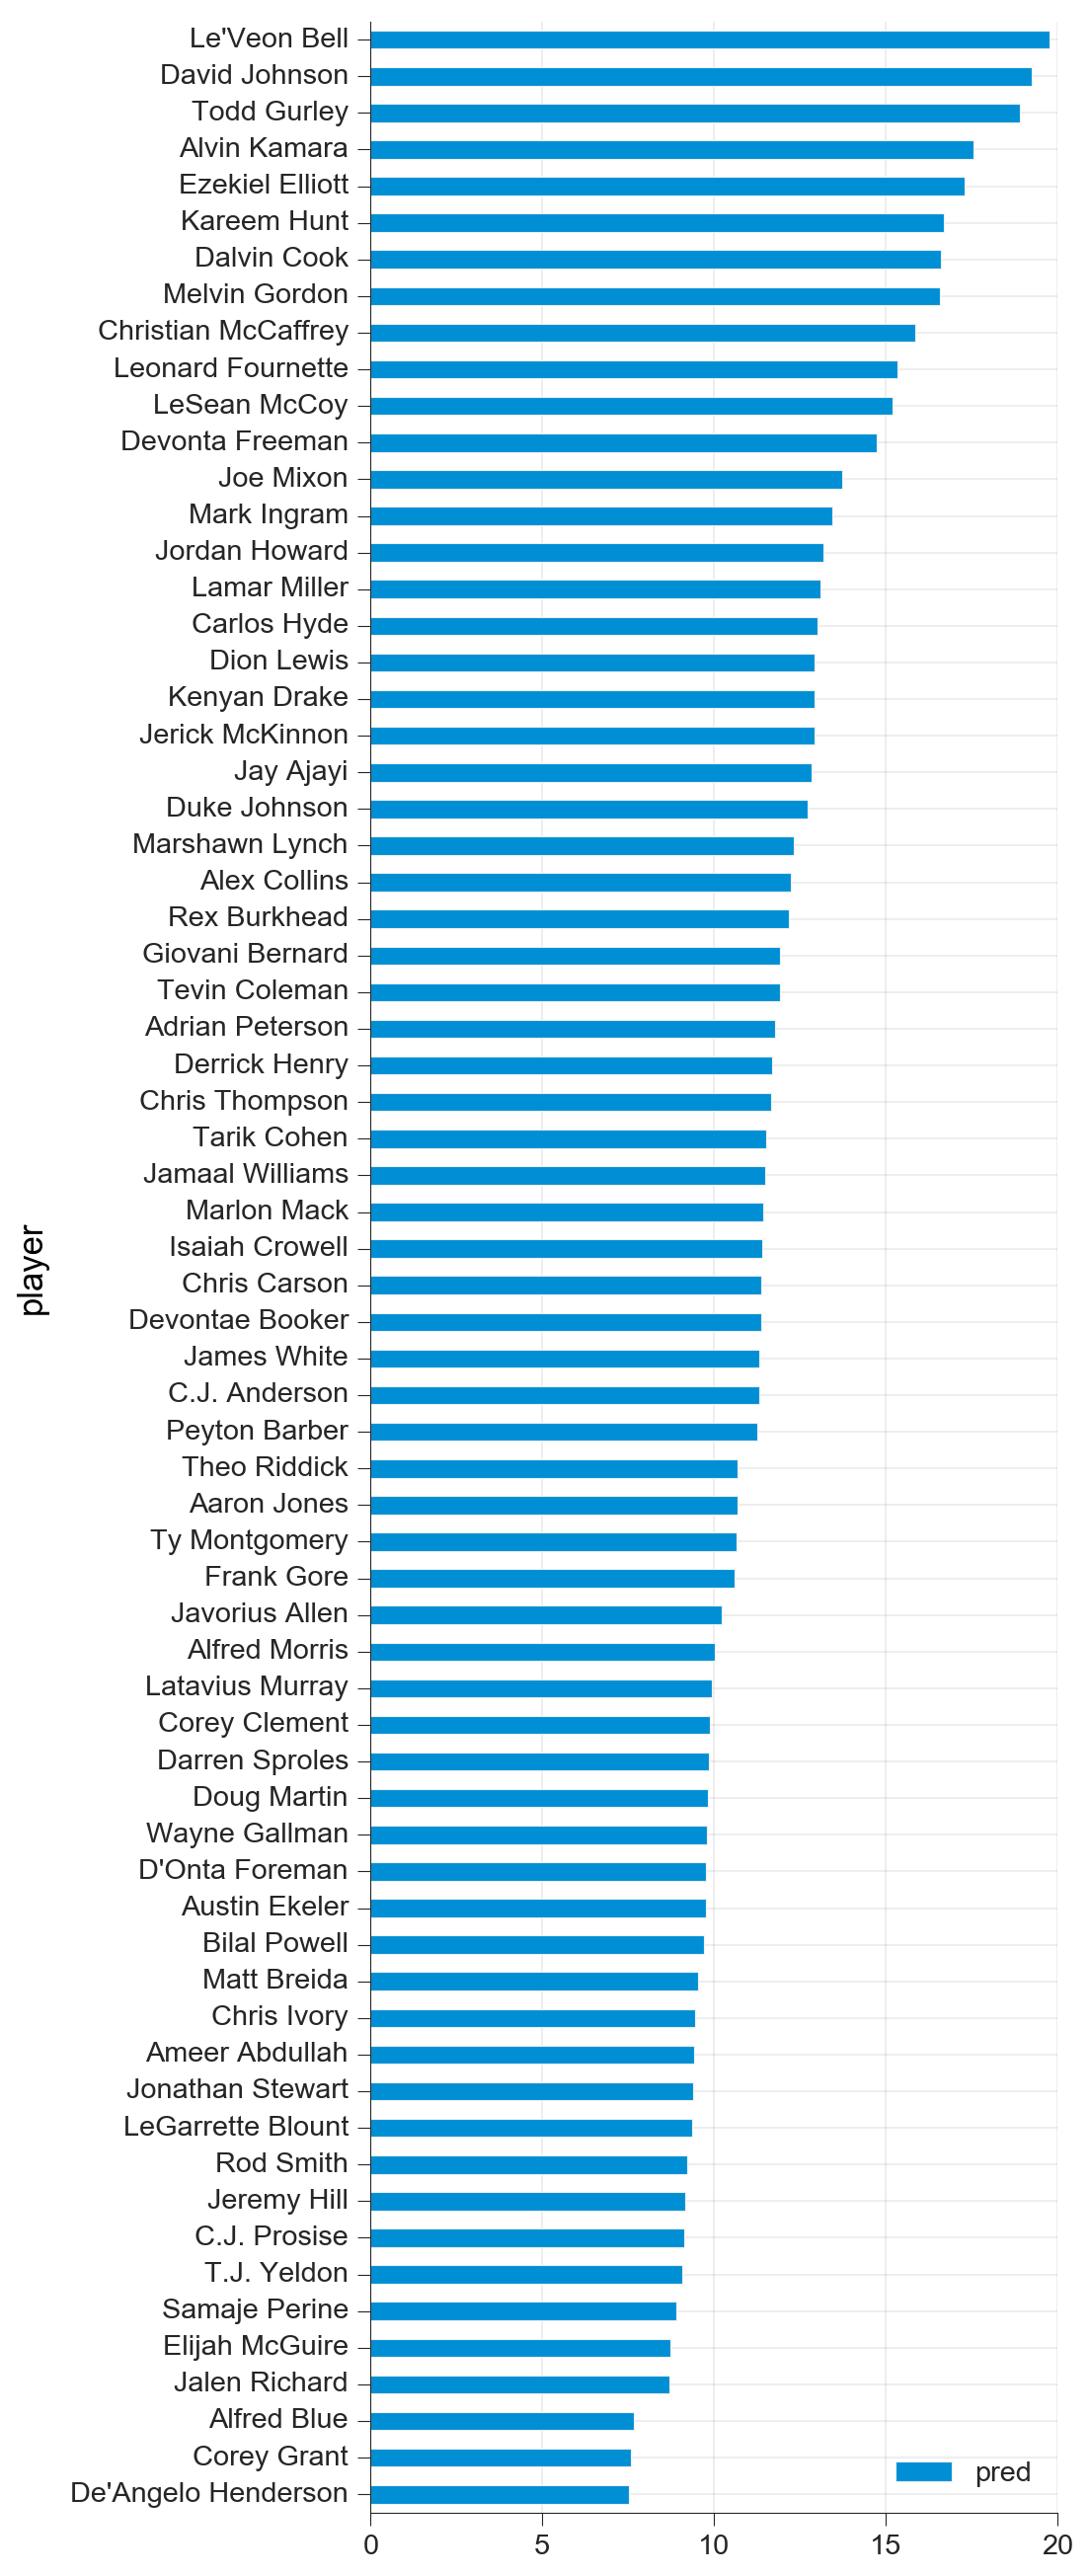

In [42]:
#==========
# Plot Predictions for Each Player
#==========

# set length of plot based on number of results
plot_length = int(df_test_results.shape[0] / 3.5)

# plot results from highest predicted FP to lowest predicted FP
df_test_results.sort_values('pred').plot.barh(x='player', y='pred', figsize=(5, plot_length));

# Clustering Players into Tiers

In [44]:
#==========
# Group Players into Clusters Using Decision Tree
#==========

df_train_results.loc[:, 'error'] = 1

# initialize cluster with train and test results
cluster = Clustering(df_train_results, df_test_results)

In [45]:
# fit decision tree and apply nodes to players
cluster.fit_and_predict_tree()

{'max_depth': 4, 'min_samples_leaf': 15, 'min_samples_split': 2, 'splitter': 'random'}
Best RMSE:  3.553
Cluster List:  [16, 8, 15, 14, 4, 7, 9]


In [49]:
_ = cluster.add_fit_metrics()

Fantasy PPG for Various Percentiles
-----------------------------------
5th percentile:  11.59
25th percentile: 15.21
50th percentile: 16.3
75th percentile: 18.89
95th percentile: 22.2

Pred to Actual Correlation
0.002


,player,pred,cluster_pred
2,Le'Veon Bell,19.757568,17.387214
5,David Johnson,19.256469,17.290913
0,Todd Gurley,18.886155,17.219745
6,Alvin Kamara,17.553805,16.963692
3,Ezekiel Elliott,17.276305,16.910362


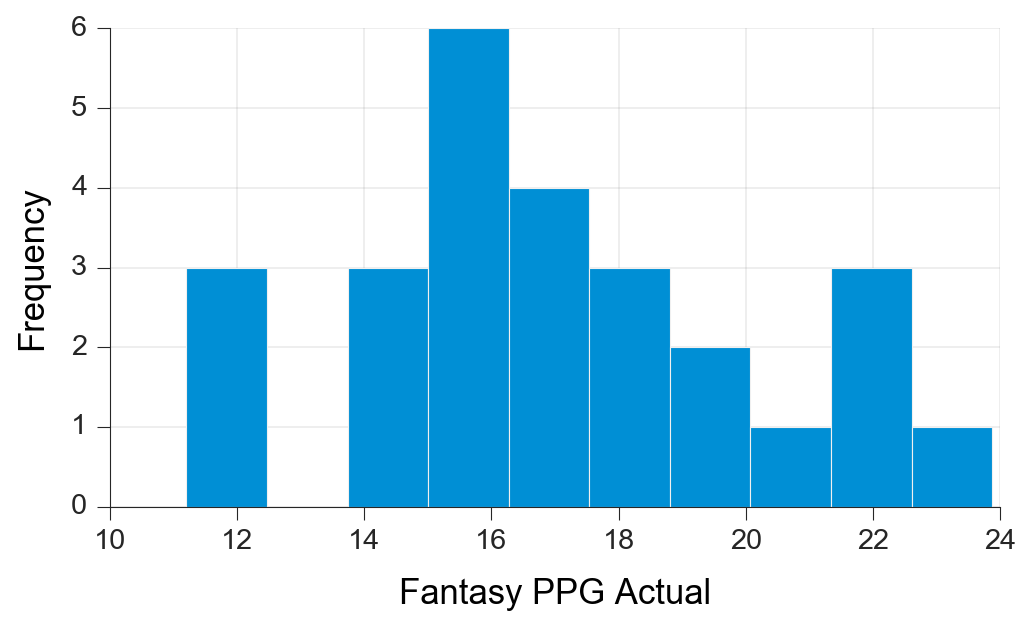

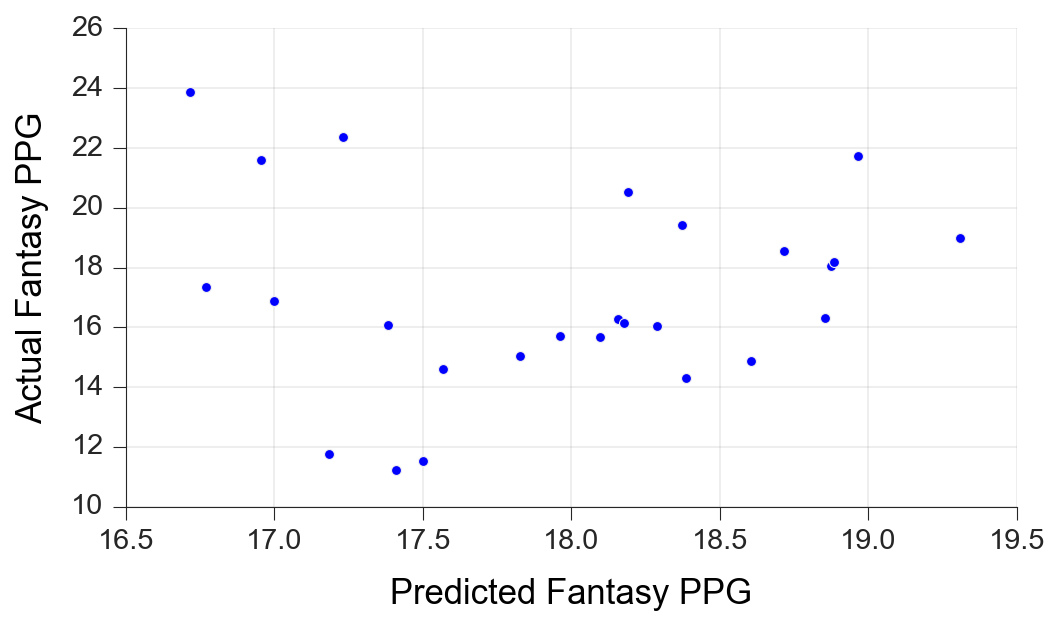

In [50]:
#==========
# Show the Results for Each Cluster
#==========

cluster.show_results(j=16)

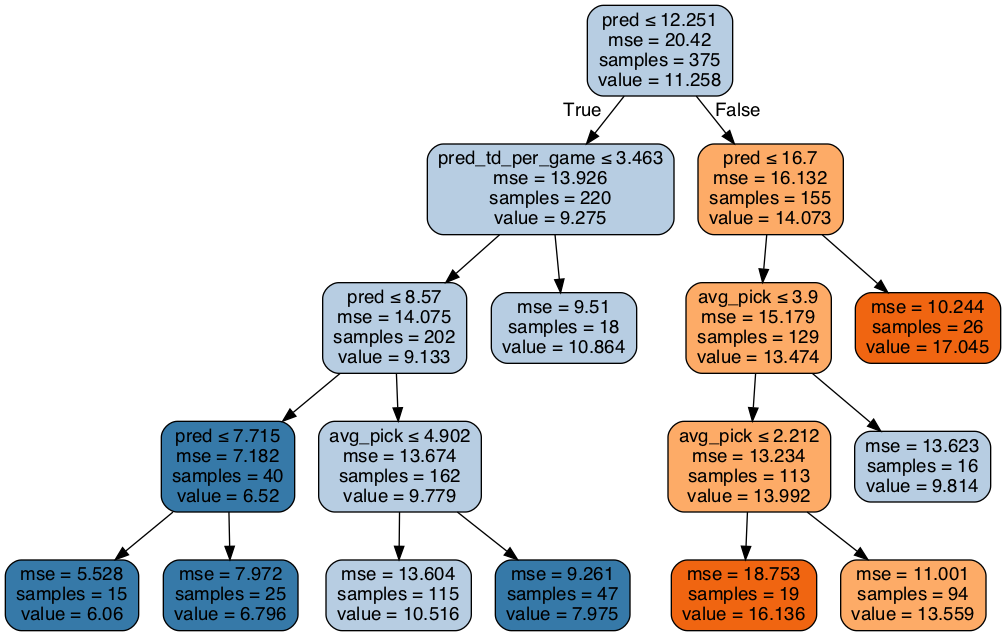

In [46]:
#==========
# Create Graph of Decision Tree Logic
#==========

cluster.tree_plot()